In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Proximal splittting for Brenier's approach: douglas-rachford solver

see paper `Optimal Transport with Proximal Splitting` and matlab code `http://www.numerical-tours.com/matlab/optimaltransp_2_benamou_brenier/`

In [1]:
# constants
n = 16
p = 16
N = n * n

# create test signals
mesh_x, mesh_y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))

gauss_grid = lambda x, y, sigma: np.exp(-((mesh_x - x)**2 + (mesh_y - y)**2) / 2 / (sigma**2))
normalize = lambda X: X / X.sum()

f0 = normalize(gauss_grid(0.3, 0.2, 0.1)+0.05)
f1 = normalize(gauss_grid(0.7, 0.6, 0.07) + 0.6* gauss_grid(0.4, 0.7, 0.07)+0.05)

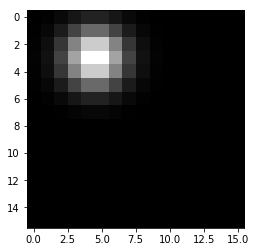

In [2]:
plt.imshow(f0, cmap='gray')

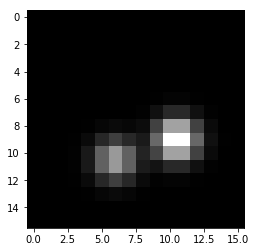

In [3]:
plt.imshow(f1, cmap='gray')

In [4]:
# basic operators

# define neumann boundary differentiation
dx = lambda u: np.concatenate((u[1:,:,:], u[-1:,:,:]), axis=0) - u
dy = lambda u: np.concatenate((u[:,1:,:], u[:,-1:,:]), axis=1) - u

# adjoint differentiasion 
# adjoint operator at least for this one can be found by doing simple algebraic math
dx_adj = lambda u: -np.concatenate((u[:1,:,:], u[1:-1,:,:]-u[:-2,:,:],-u[-2:-1,:,:]), axis=0)
dy_adj = lambda u: -np.concatenate((u[:,:1,:], u[:,1:-1,:]-u[:,:-2,:],-u[:,-2:-1,:]), axis=1)

# divergence is adjoint of negetive gradient if boundary intergral is zero by stokes theorem
grad = lambda u: np.stack((dx(u), dy(u)), axis=-1) # when u is a scalar field
# input m(x, t)=[m_x(x,t), m_y(x, t)] is a 2D vector field in total [n, n, p, 2] size, output is [n, n, p]
div = lambda m: -dx_adj(m[:,:,:,0]) + -dy_adj(m[:,:,:,1]) 
# but why don't we use this?? 
# my_div = lambda v: dx(v[:,:,:,0]) + dy(v[:,:,:,1])

# time derivative
dt = lambda f: np.concatenate((f[:,:,1:], f[:,:,-1:]), axis=2) - f # time derivative on f, size:[n, n, p]->[n, n, p]
dt_adj = lambda u: -np.concatenate((u[:,:,:1], u[:,:,1:-1]-u[:,:,:-2],-u[:,:,-2:-1]), axis=2) #

# A and A_adj
# A -- input: w = (m, t) = [n, n, p, 3] (3=2 for m+1 for t) , output, [div(m)+dt(f), f0, f1] = [[n, n, p], [n, n], [n, n]]->in all [n, n, p+2]
A = lambda w: np.concatenate((div(w[:,:,:,:2]) + dt(w[:,:,:,2]), w[:,:,:1,2], w[:,:,-1:,2]), axis=2)
# A_adj -- input: r=(s, r0, r1)=[n, n, p+2]=[[n, n, p], [n, n], [n, n]], output: [grad s, dt_adj s + U(r0+r1)]=[[n, n, p, 2], [n, n, p]]=[n, n, p, 3]
U = lambda r0, r1: np.concatenate([r0, np.zeros([n, n, p-2]), r1], axis=2) # the padding operator, [[n, n, 1], [n, n, 1]] -> [[n, n, p]]
add_dim_4 = lambda x: x.reshape([x.shape])
A_adj = lambda r: np.concatenate((-grad(r[:,:,:p]), np.expand_dims((U(r[:,:, -2:-1], r[:,:,-1:])+dt_adj(r[:,:,:p])), 3)), axis=3)

In [5]:
# helpers
def check_adjoint(A,A_adj,shape):
    x = np.random.randn(*shape)
    Ax = dx(x)
    y = np.random.randn(*Ax.shape)
    Ay = dx_adj(y)
    result = (x * Ay).sum() - (Ax * y).sum()
    print("<Ax,y>-<x,A*y>=", result)
    #return abs(result) < eps
    
def print_matlab(arr): 
    # print the np array in matlab format
    s = [i for i in range(len(arr.shape))]
    arr = arr.transpose(list(reversed(s[2:]))+ [0, 1])
    print(arr)
        
pm = print_matlab

In [6]:
#check adjoint
check_adjoint(dy, dy_adj, [n, n, p])
check_adjoint(grad, lambda v:-div(v), [n, n, p])
check_adjoint(dt, dt_adj, [n, n, p])
check_adjoint(A, A_adj, [n, n, p, 3])

<Ax,y>-<x,A*y>= 2.842170943040401e-14
<Ax,y>-<x,A*y>= 0.0
<Ax,y>-<x,A*y>= 1.4210854715202004e-14
<Ax,y>-<x,A*y>= -5.684341886080802e-14


In [7]:
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import LinearOperator

# ProxJ
def Proxj(lbda):
    def Proxj_helper(wi): # for each (m, f) pointset
        m0 = wi[:2]
        f0 = wi[2]
        # solve for f
        roots = np.roots(np.r_[1, (4*lbda-f0), (4*lbda**2-4*lbda*f0), -(lbda*m0.dot(m0)+4*lbda**2*f0)])
        f = sorted(list(filter(lambda x: abs(x.imag)<1e-6, roots)), reverse=True)[0].real
        m = m0 / (1+ 2*lbda / f)
        return np.array([m[0], m[1], f])
    return Proxj_helper

#Proxj_helper = lambda wi, lbda: Proxj(wi, lbda)
# input : [n, n, p, 3] -> output:[n, n, p, 3]
ProxJ = lambda w, lbda: np.apply_along_axis(Proxj(lbda), 3, w)

def AA_adj_inv(r_Aw): 
    # solve for AA* X = r_Aw, return X = (AA*)^-1*r_Aw
    def AA_adj_vec(x):
        x = x.reshape(n, n, p+2)
        return A(A_adj(x)).reshape(-1)
    AA_adj_LinearOp = LinearOperator([n*n*(p+2), n*n*(p+2)], AA_adj_vec)
    result = cg(AA_adj_LinearOp, r_Aw.reshape(-1))
    #print("CG:", result[1])
    return result[0].reshape(n, n, p+2)
# ProxC    input : w [n, n, p, 3]-> output: [n, n, p, 3]
ProxC = lambda w : w + A_adj(AA_adj_inv(rb-A(w)))

# rProx
rProxJ = lambda w, lbda: 2 * ProxJ(w, lbda) - w

rb = np.concatenate((np.zeros([n, n, p]), f0.reshape(n,n,1), f1.reshape(n,n,1)), axis=2) # boundary condition

J = lambda w: (((w[:,:,:,0] ** 2) + (w[:,:,:,1] ** 2)) / w[:,:,:,2]).sum()
cstr = lambda w: ((rb-A(w)) ** 2).sum()

In [13]:
# initialization
t_steps = np.linspace(0,1,p-1)[1:]
f = np.stack([f0] + [ (f0*t+(1-t)*f1) for t in t_steps] + [f1], axis=-1) # [n, n, p]
m = np.zeros([n, n, p, 2])
w = np.concatenate([m, f.reshape(n, n, p, 1)], axis=3)
w_bar = w.copy()
w = ProxC(w)
J(w_bar)

# optimization step
mu = 1
lbda = 1
J_log = []
cstr_log = []
for i in range(500):
    if (i%10==0):
        print("iteration:", i)
    w = ProxC(w_bar);
    temp = 2 * w - w_bar
    w_bar = (1-mu/2) * w_bar + mu/2*rProxJ(temp, lbda)
    J_log.append(J(w))
    cstr_log.append(cstr(w))

iteration: 0
iteration: 10
iteration: 20
iteration: 30
iteration: 40
iteration: 50
iteration: 60
iteration: 70
iteration: 80
iteration: 90
iteration: 100
iteration: 110
iteration: 120
iteration: 130
iteration: 140
iteration: 150
iteration: 160
iteration: 170
iteration: 180
iteration: 190
iteration: 200
iteration: 210
iteration: 220
iteration: 230
iteration: 240
iteration: 250
iteration: 260
iteration: 270
iteration: 280
iteration: 290
iteration: 300
iteration: 310
iteration: 320
iteration: 330
iteration: 340
iteration: 350
iteration: 360
iteration: 370
iteration: 380
iteration: 390
iteration: 400
iteration: 410
iteration: 420
iteration: 430
iteration: 440
iteration: 450
iteration: 460
iteration: 470
iteration: 480
iteration: 490


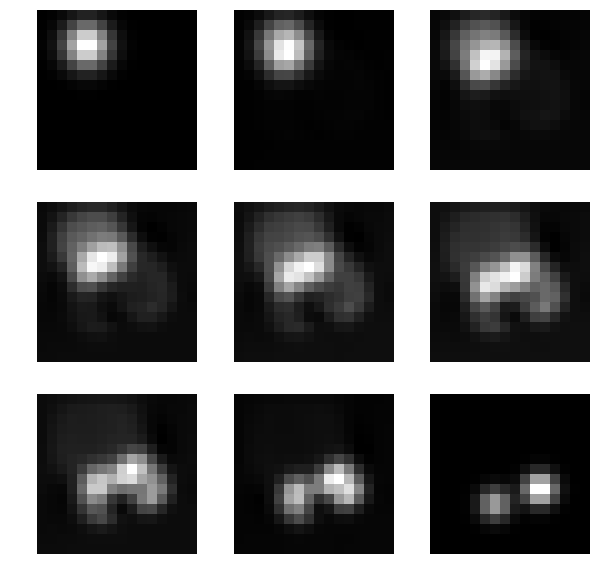

In [14]:
plot_n = 3
f_idx = np.array(np.linspace(0, p-1, plot_n * plot_n), int)

fig, axs = plt.subplots(plot_n, plot_n, figsize=(10, 10))
for i in range(plot_n):
    for j in range(plot_n):
        axs[i, j].imshow(w[:, :, f_idx[plot_n * i+j], -1], cmap='gray')
        axs[i, j].axis('off')

Text(0.5,1,'J vs. iteration')

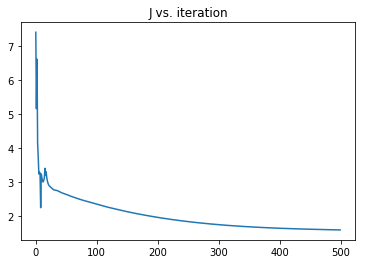

In [15]:
plt.figure()
plt.plot(J_log)
plt.title("J vs. iteration")

Text(0.5,1,'constraints_MSE vs. iteration')

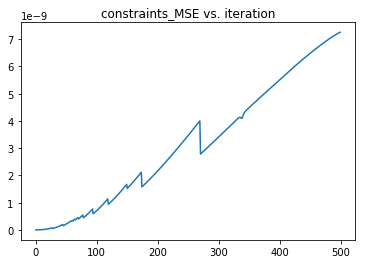

In [16]:
plt.figure()
plt.plot(cstr_log)
plt.title("constraints_MSE vs. iteration")

# Entropy regularized OT

see paper `Sinkhorn Distances: Lightspeed Computation of Optimal Transport` and `Computational Optimal Transport`

In [2]:
# intialize 1D Gaussian Histogram
n = 256
x = np.linspace(0, 1, n)

gaussian = lambda x, mean, sigma : np.exp(-(x - mean)**2 / 2 / (sigma**2))
normalize = lambda X: X / X.sum()

s = normalize(gaussian(x, 0.4, 0.1)+ 0.4 * gaussian(x, 0.8, 0.2)).reshape(-1, 1)
d = normalize(gaussian(x, 0.75, 0.2)*0.2+gaussian(x, 0.1, 0.05)).reshape(-1, 1)

(-0.05, 1.05, -0.000488356176257353, 0.010351989684022154)

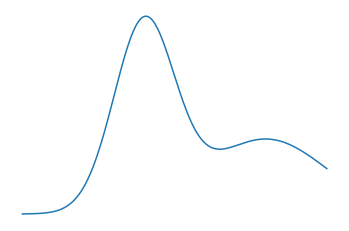

In [3]:
plt.plot(x, s)
plt.axis('off')

(-0.05, 1.05, -0.0006492837784656542, 0.019362217981820924)

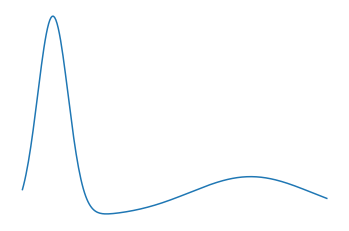

In [4]:
plt.plot(x, d)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

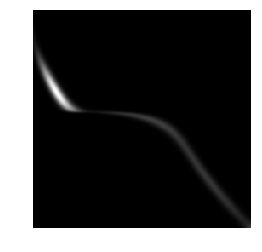

In [6]:
# generate u and v
u = np.ones([n, 1]) / n
v = np.ones([n, 1]) / n

gamma = 0.001
K = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        K[i, j] = np.exp(-(x[i] - x[j])**2 / gamma)

iter_n = 100;
for i in range(iter_n): # truly light speed
    u = s / K.dot(v) # matrix mult, elementwise div
    v = d / (K.T).dot(u)

T = u * K * v.reshape(-1) # elementwize mult

plt.imshow(T, cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

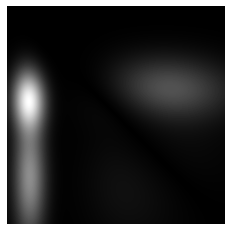

In [6]:
# generate u and v
u = np.ones([n, 1]) / n
v = np.ones([n, 1]) / n

gamma = 0.001
K = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        K[i, j] = np.abs(-(x[i] - x[j])/ gamma)

iter_n = 100;
for i in range(iter_n): # truly light speed
    u = s / K.dot(v) # matrix mult, elementwise div
    v = d / (K.T).dot(u)

T = u * K * v.reshape(-1) # elementwize mult

plt.imshow(T, cmap='gray')
plt.axis('off')